### Imports

In [1]:
from matplotlib import pyplot as plt
from data import load_data, load_narx_data
from matplotlib import pyplot as plt
import numpy as np
import torch
from data import load_narx_data
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, Matern, Product
from scipy.sparse import csr_matrix
from util_fun import calculate_error_nrms
from math import sqrt

In [2]:
n_a, n_b = 2, 2
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 1000 # total number of points to consider from the larger dataset (starting from index 0)
restart = 2

In [3]:
Xtrain,Ytrain = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=True)
Xval,Yval = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=True)
Xtest,Ytest = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=True)

Considering 1000 datapoints
Using 600 datapoints for training set
Considering 1000 datapoints
Using 200 datapoints for validation set
Considering 1000 datapoints
Using 200 datapoints for test set


In [4]:
# Standard settings
kernel = RBF(length_scale_bounds=[30,100]) + WhiteKernel(noise_level_bounds=[0.001, 10])
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=restart)

In [5]:
# Standard settings
# kernel = RBF(length_scale=40) + WhiteKernel(noise_level=0.01)
# reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=restart)

Create sparse matrices

In [6]:
XtrainSparse = csr_matrix(Xtrain)
YtrainSparse = csr_matrix(Ytrain)

In [7]:
Yval = Yval.numpy()  # Convert Yval from Tensor to NumPy array
Ytest = Ytest.numpy()  # Convert Ytest from Tensor to NumPy array

## Fit the GP

In [8]:
reg.fit(XtrainSparse.toarray(), Ytrain)

c:\Users\20191695\Anaconda3\envs\ml4sc\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 30. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2)

In [9]:
def get_NARX_data(ulist, data, na, nb):
    # iteratively uses the given f to find the new output.
    
    # init upast and ypast as lists.
    upast = [0]*nb
    ypast = [0]*na
    
    ylist = []
    for index,unow in enumerate(ulist):
        #compute the current y given by f
        ynow = data[index]
        
        #update past arrays
        upast.append(unow) #add an element on the end
        upast.pop(0)       #remove the fist element
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
    return np.array(ylist) #return result

Considering 1000 datapoints
Using 200 datapoints for test set
NRMS test prediction: 0.27993963536705


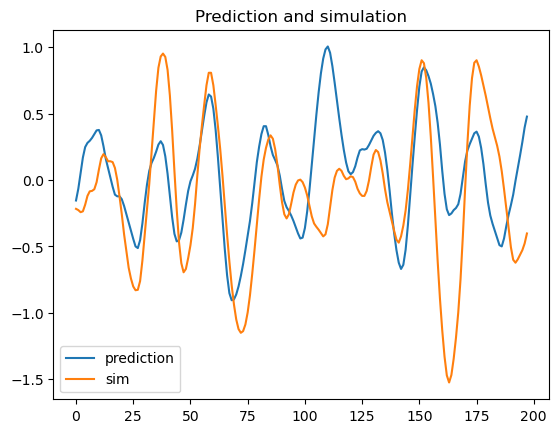

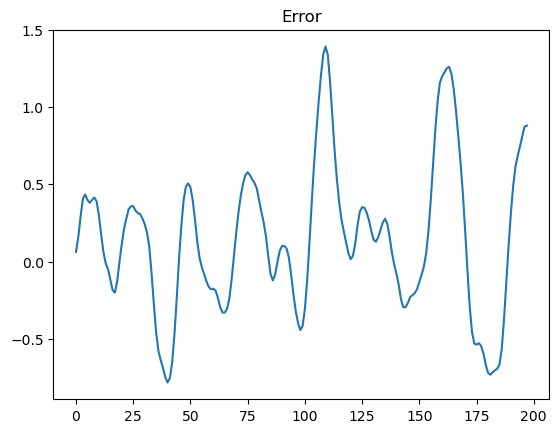

NRMS test simulation: 1.2532287774572148


In [10]:
Xtest, Ytest = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=True)
Ytest_pred = reg.predict(Xtest)
print('NRMS test prediction:', calculate_error_nrms(Ytest_pred, Ytest))


# try:
ytest_sim = get_NARX_data(Xval,Yval, n_a, n_b) #explodes
NRMS_sim = calculate_error_nrms(ytest_sim, Ytest)
plt.figure()
plt.plot(Ytest)
plt.plot(ytest_sim)
plt.title("Prediction and simulation")
plt.legend(['prediction','sim'])

plt.figure()
plt.plot(Ytest-ytest_sim)
plt.title("Error")
plt.show()
# except ValueError:
#     NRMS_sim = float('inf')
print('NRMS test simulation:', NRMS_sim)

In [11]:
Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 

NRMS = np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)

print(f'Validation NRMS= {NRMS}')

Validation NRMS= 0.2854977074418624


In [12]:
print(reg.kernel_)

RBF(length_scale=30) + WhiteKernel(noise_level=0.011)


Make some nice plots

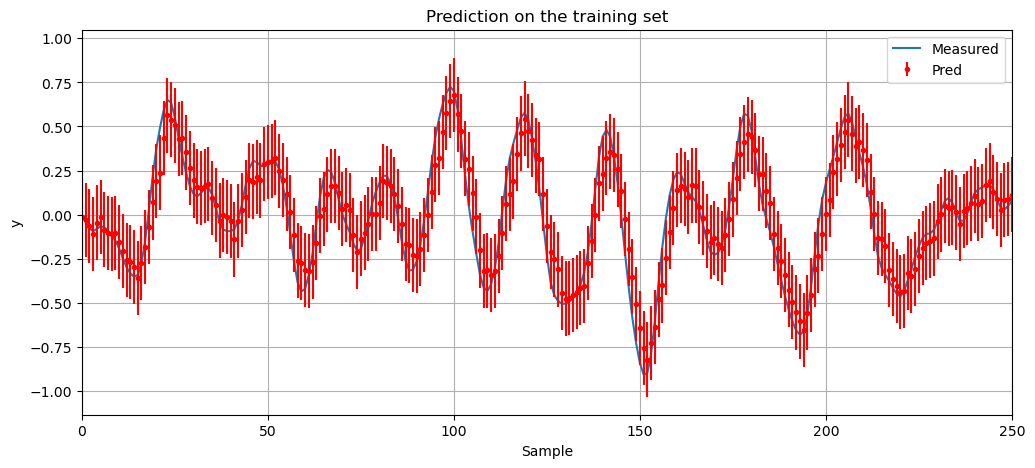

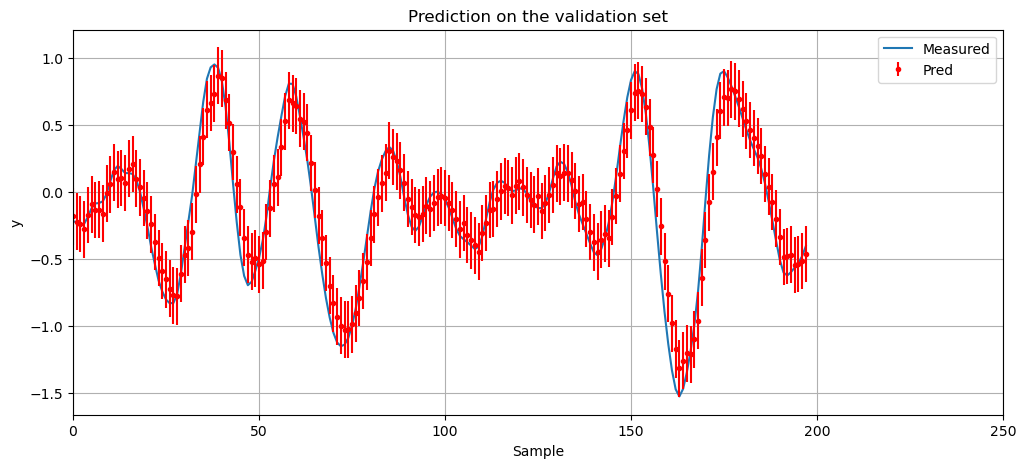

Validation NRMS= 0.2854977074418624


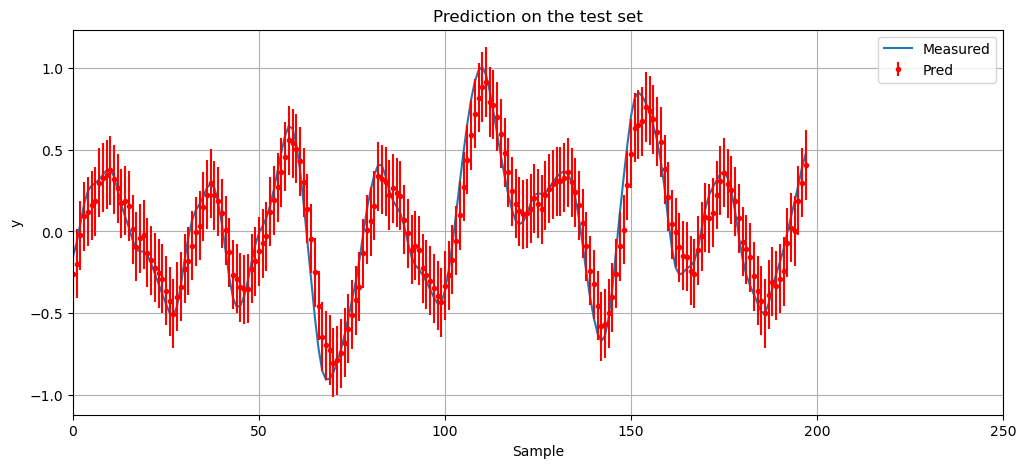

Test NRMS = 0.27993963536705


In [13]:
# Plotting
Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain, return_std=True) 
plt.figure(figsize=(12, 5)) 
plt.plot(Ytrain) 
plt.title('Prediction on the training set')
plt.errorbar(np.arange(len(Xtrain)), Ytrain_pred, yerr=2 * Ytrain_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

plt.figure(figsize=(12, 5)) 
plt.title('Prediction on the validation set')
plt.plot(Yval) 
Yval_pred, Yval_pred_std = reg.predict(Xval, return_std=True) 
plt.errorbar(np.arange(len(Xval)), Yval_pred, yerr=2 * Yval_pred_std, fmt='.r') 
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred']) 
plt.xlim([0, 250])
plt.show()


print(f'Validation NRMS= {np.mean((Yval_pred-Yval)**2)**0.5/np.std(Yval)}')

plt.figure(figsize=(12, 5))
plt.title('Prediction on the test set')
plt.plot(Ytest)
ytest_pred, ytest_pred_std = reg.predict(Xtest, return_std=True)
plt.errorbar(np.arange(len(Xtest)), ytest_pred, yerr=2 * ytest_pred_std, fmt='.r')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('y')
plt.legend(['Measured', 'Pred'])
plt.xlim([0, 250])
plt.show()

print(f'Test NRMS = {calculate_error_nrms(ytest_pred, Ytest)}')

# Results

Time calculation: <br>
1000 items takes 0.7 sec